In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
import h2o
from h2o.automl import H2OAutoML
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator, H2OGeneralizedLinearEstimator

h2o.init(max_mem_size = '12G', ip = '127.0.0.1', port = "54321")

Checking whether there is an H2O instance running at http://127.0.0.1:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "13.0.2" 2020-01-14; Java(TM) SE Runtime Environment (build 13.0.2+8); Java HotSpot(TM) 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from /Users/wbchoi/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/q1/z7qbw9z12vq12k5vd65yw2tw0000gn/T/tmpfm0mcpzg
  JVM stdout: /var/folders/q1/z7qbw9z12vq12k5vd65yw2tw0000gn/T/tmpfm0mcpzg/h2o_wbchoi_started_from_python.out
  JVM stderr: /var/folders/q1/z7qbw9z12vq12k5vd65yw2tw0000gn/T/tmpfm0mcpzg/h2o_wbchoi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.5
H2O_cluster_version_age:,1 month and 8 days
H2O_cluster_name:,H2O_from_python_wbchoi_ade65v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


# Auto ML (H2O)

In [3]:
h2o_data = h2o.import_file('/Users/wbchoi/PycharmProjects/ai_projects/C_ITS/prediction_modeling/full_data_kma_hours_lightgbm_feature_extract.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
h2o_data.shape

(15797629, 37)

In [5]:
h2o_data.head(5)

SUB_YN,ROAD_TYPE,REST_VEH,MAX_SPD,LANES,CW_YN,BUS_YN,A3_ROADTYPE_1_YN,A1_LANE_04_YN,A1_BARR_03_YN,A1_BARR_02_YN,S_P_UTERNX_CNT,SN_P_HDUFID_CNT,SF_P_ALL_CNT,SF_PL_CW_CNT,SF_L_1_CNT,SUB_CNT,NODE_LANES_CNT,NODE_INTERS_CNT,CW_CNT,BUS_CNT,A3_ROADTYPE_3_CNT,A3_ROADTYPE_1_CNT,A2_STOP_2_CNT,A2_STOP_1_CNT,A1_LANE_04_CNT,A1_BARR_05_CNT,A1_BARR_03_CNT,A1_BARR_02_CNT,topis_22_07,pop_22_07,WS,WD,TEMP,RF,HM,SAGO_YN
0,0,0,60,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.222222,0.142857,0,0,0,0,0,0,0,0,0.250954,0.0249517,0.0642202,0.943889,0.419935,0,0.727227,0
0,0,0,60,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.222222,0.142857,0,0,0,0,0,0,0,0,0.250954,0.0249517,0.146789,0.911667,0.418301,0,0.707207,0
0,0,0,60,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.222222,0.142857,0,0,0,0,0,0,0,0,0.250954,0.0249517,0.100917,0.956667,0.410131,0,0.755255,0
0,0,0,60,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.222222,0.142857,0,0,0,0,0,0,0,0,0.250954,0.0249517,0.100917,0.963611,0.410131,0,0.764765,0
0,0,0,60,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.222222,0.142857,0,0,0,0,0,0,0,0,0.250954,0.0249517,0.12844,0.973333,0.405229,0,0.775275,0


In [6]:
# target 변수 (교통사고 유/무) 지정
h2o_data[-1] = h2o_data[-1].asfactor()

In [7]:
predictors = h2o_data.columns[0:37]

response = 'SAGO_YN'

In [8]:
# train : valid : test = 0.7 : 0.1 : 0.2
# train, valid, test = h2o_data.split_frame(ratios = [0.7, 0.1], seed = 7)

# train : test = 0.8 : 0.2
train, test = h2o_data.split_frame(ratios = [0.8], seed = 7)

# GBM Hyper Parameter tuning

In [10]:
sample_factors = [0.5, 1.0]
max_size = 0.85

cov_gbm = H2OGradientBoostingEstimator(balance_classes = True, class_sampling_factors = sample_factors, max_after_balance_size = max_size,
                                       seed = 1234)

# cov_gbm.train(x = predictors, y = response, training_frame = train, validation_frame = valid)
cov_gbm.train(x = predictors, y = response, training_frame = train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [11]:
print('logloss', cov_gbm.logloss(valid = False))

logloss 0.00377554644248851


In [14]:
# hyper_params = {'class_sampling_factors': [[0.01, 1.0], [0.02, 1.0], [0.05, 1.0], [0,1, 1.0], [0.2, 1.0]],
#               'max_after_balance_size': [0.05, 0.2, 0.5, 0.75, 0.85, 1.0, 1.5, 2.5, 5.0]}

hyper_params = {'class_sampling_factors': [[0.01, 1.0], [0.02, 1.0], [0.05, 1.0]],
               'max_after_balance_size': [0.05, 0.2, 0.5, 0.75, 1.0]}

# build grid search with previously made GBM and hyperparameters
cov_gbm_2 = H2OGradientBoostingEstimator(seed = 777, balance_classes = True, nfolds = 5)

grid = H2OGridSearch(model = cov_gbm_2, hyper_params = hyper_params,
                     search_criteria = {'strategy': "Cartesian"})

# train using the grid
# grid.train(x = predictors, y = response, training_frame = train, validation_frame = valid)
grid.train(x = predictors, y = response, training_frame = train)

# sort the grid models by logloss
sorted_grid = grid.get_grid(sort_by='logloss', decreasing=False)
print(sorted_grid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
     class_sampling_factors max_after_balance_size  \
0               [0.01, 1.0]                   0.05   
1               [0.01, 1.0]                   0.75   
2               [0.01, 1.0]                    1.0   
3               [0.01, 1.0]                    0.2   
4               [0.01, 1.0]                    0.5   
5               [0.02, 1.0]                   0.75   
6               [0.02, 1.0]                    1.0   
7               [0.02, 1.0]                   0.05   
8               [0.02, 1.0]                    0.2   
9               [0.02, 1.0]                    0.5   
10              [0.05, 1.0]                   0.75   
11              [0.05, 1.0]                    1.0   
12              [0.05, 1.0]                   0.05   
13              [0.05, 1.0]                    0.2   
14              [0.05, 1.0]                    0.5   

                                                      

In [9]:
sample_factors = [0.02, 1.0]
max_param = 1.0

In [10]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
'''균형 샘플링의 경우 더 높은 사양의 하드웨어 환경에서 훈련 필요!!!!!!!!!!!!!!!!!!!!!!!!'''
# aml = H2OAutoML(max_models=5, seed=777, max_runtime_secs = 7200, sort_metric = "logloss", 
#    nfolds = 5, balance_classes = True, include_algos = ['GBM'])

aml = H2OAutoML(max_models=5, seed=777, max_runtime_secs = 7200, sort_metric = "logloss", 
        class_sampling_factors = sample_factors, max_after_balance_size = max_param, nfolds = 5,
          balance_classes = True, include_algos = ['GBM'])

'''aml = H2OAutoML(max_models=10, seed=777, max_runtime_secs = 5400, sort_metric = "logloss", 
            balance_classes = True,  class_sampling_factors = sample_factors, max_after_balance_size = max_param,
            nfolds = 10, exclude_algos = ['DeepLearning' , 'XGBoost'])'''

# aml.train(x=predictors, y=response, training_frame=train, validation_frame = valid)
aml.train(x=predictors, y=response, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [11]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse
GBM_5_AutoML_20200727_130653,0.00198063,0.826328,0.00510163,0.458258,0.0154208,0.000237803
GBM_2_AutoML_20200727_130653,0.00204957,0.82611,0.00419209,0.456096,0.0159304,0.000253779
GBM_3_AutoML_20200727_130653,0.00209732,0.824613,0.00404185,0.470793,0.0163808,0.000268331
GBM_4_AutoML_20200727_130653,0.00212782,0.818761,0.00384688,0.468195,0.0164446,0.000270424
GBM_1_AutoML_20200727_130653,0.00257382,0.819531,0.0033793,0.449283,0.0201312,0.000405264


In [12]:
# auto ml leaderboard 1순위 모델 저장
save_model_id = h2o.get_model(aml.leaderboard.as_data_frame()['model_id'][0])

In [13]:
'''leader model 기반 test set prediction'''
# To generate predictions on a test set, you can make predictions
# directly on the `"H2OAutoML"` object or on the leader model
# object directly
preds = aml.predict(test)
preds
# or:
# preds = aml.leader.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
0,0.999953,4.66791e-05
0,0.999934,6.60852e-05
0,0.999948,5.17008e-05
0,0.999961,3.93436e-05
0,0.999964,3.57625e-05
0,0.999933,6.65374e-05
0,0.999936,6.39168e-05
0,0.99993,7.0165e-05
0,0.999956,4.36692e-05
0,0.999935,6.49763e-05


In [14]:
y_test_df = test['SAGO_YN'].as_data_frame()
y_test = y_test_df.to_numpy()

In [15]:
y_pred_df = preds['predict'].as_data_frame()
y_pred = y_pred_df.to_numpy()

In [16]:
y_test

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [17]:
y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

# test set의 Confusion Matrix, AUC, ROC curve

In [18]:
# Confusion Matrix의 4가지 결과값 도출
cm = confusion_matrix(y_test, y_pred)

In [19]:
tn = cm[0,0]
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]

acc = (tp + tn) / (tp + tn + fp + fn)
prec = tp / (tp+fp)
sen = tp / (tp+fn)
spec = tn / (fp + tn)

print('정확도 (Accuracy): %f , 정밀도 (Precision): %f , 재현율 (Recall): %f , 특이도 (Specificity): %f' % (acc, prec, sen, spec))

정확도 (Accuracy): 0.991185 , 정밀도 (Precision): 0.006624 , 재현율 (Recall): 0.245283 , 특이도 (Specificity): 0.991360


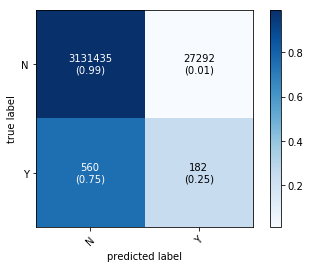

In [20]:
class_names = ['N', 'Y']
fig, ax = plot_confusion_matrix(conf_mat = cm, show_absolute=True, show_normed=True, colorbar=True, class_names = class_names)

plt.rcParams["figure.figsize"] = (5, 5)
plt.show()

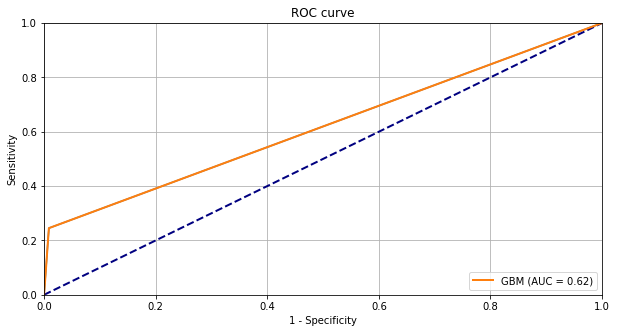

In [21]:
# ROC 커브 및 AUC 도출
FPR, TPR, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(10,5))  # figsize in inches
plt.plot(FPR, TPR)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 50%
plt.plot(FPR, TPR, lw=2, label='GBM (AUC = %0.2f)' % auc(FPR, TPR))
plt.title('ROC curve')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

In [164]:
# Get leaderboard with `extra_columns` = 'ALL'
lb = h2o.automl.get_leaderboard(aml, extra_columns = 'ALL')
lb

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms
GBM_5_AutoML_20200712_175309,0.0287975,0.806479,0.0764156,0.418298,0.0718855,0.00516753,4222,0.005234
GBM_grid__1_AutoML_20200712_175309_model_1,0.0289333,0.800134,0.0755738,0.421598,0.0718816,0.00516697,1932,0.003294
GBM_grid__1_AutoML_20200712_175309_model_5,0.0289336,0.805325,0.0722375,0.426093,0.0720404,0.00518983,2271,0.002231
GBM_2_AutoML_20200712_175309,0.0290145,0.800645,0.0709508,0.425785,0.0720884,0.00519674,2322,0.002069
GBM_1_AutoML_20200712_175309,0.0290603,0.79956,0.0714314,0.431837,0.0720208,0.00518699,2079,0.002117
GBM_3_AutoML_20200712_175309,0.0290869,0.80121,0.0694427,0.425021,0.072169,0.00520837,2127,0.002658
GBM_grid__1_AutoML_20200712_175309_model_4,0.0291645,0.798448,0.0652931,0.429315,0.072154,0.00520621,1796,0.002198
GBM_4_AutoML_20200712_175309,0.0292785,0.799852,0.0659844,0.424257,0.0723597,0.00523592,2581,0.002326
GBM_grid__1_AutoML_20200712_175309_model_2,0.0296669,0.794792,0.0633127,0.435793,0.0727818,0.00529719,2376,0.002248
GBM_grid__1_AutoML_20200712_175309_model_3,0.0301988,0.783623,0.0626328,0.434087,0.0730809,0.00534082,1743,0.002333


In [22]:
# save the model
model_path = h2o.save_model(model=save_model_id, path="automl_save_model/", force=True)
print(model_path)

/Users/wbchoi/PycharmProjects/ai_projects/C_ITS/prediction_modeling/automl_save_model/GBM_5_AutoML_20200727_130653


In [25]:
# load the model
load_model_test = h2o.load_model('/Users/wbchoi/PycharmProjects/ai_projects/C_ITS/EDA/automl_save_model/GBM_5_AutoML_20200710_213328')